In [50]:
from models.network_swinir import SwinIR
import torch 
from torchvision.io import read_image
from torchvision.transforms import Resize
import glob
from train import DIV2K
from gradients import Mixed2RGB, RGB2Mixed

data = DIV2K("/shared/DIV2K/DIV2K_valid_HR//")

x,y = data[-1]
upscale = 2
window_size = 8
height = (256 // upscale // window_size + 1) * window_size
width = (256 // upscale // window_size + 1) * window_size
print(height,width)
model = SwinIR(upscale=2, img_size=(256, 256), patch_size=1,
                window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
                embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffle', use_gradients=True).cuda()

y = model(x.unsqueeze(0).cuda()).size()
print(y)
m2 = Mixed2RGB((256,256)).cuda()
m1 = RGB2Mixed().cuda()

m2(m1(x.unsqueeze(0).cuda())).size()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


136 136


KeyboardInterrupt: 

In [ ]:
x = torch.randn(5, 3, 256 ,256)
x = read_image("/shared/DIV2K/DIV2K_train_HR/0001.png").unsqueeze(0)
print(x.size())
resize = Resize((256,256))
x =resize(x).cuda()
model = SwinIR(patch_size=1, window_size=4, img_size=(256,256), ).cuda()

model(x).size()

In [9]:
upscale = 2
window_size = 8
height = (1024 // upscale // window_size + 1) * window_size
width = (720 // upscale // window_size + 1) * window_size
model = SwinIR(upscale=2, img_size=(height, width),
                window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
                embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect').cuda()
x = read_image("/shared/DIV2K/DIV2K_train_HR/0001.png").unsqueeze(0)
resize = Resize((256,256))
x =resize(x).cuda()

model(x).size()

torch.Size([1, 3, 512, 512])

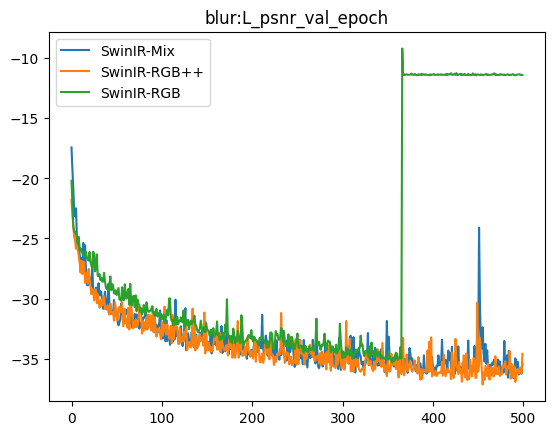

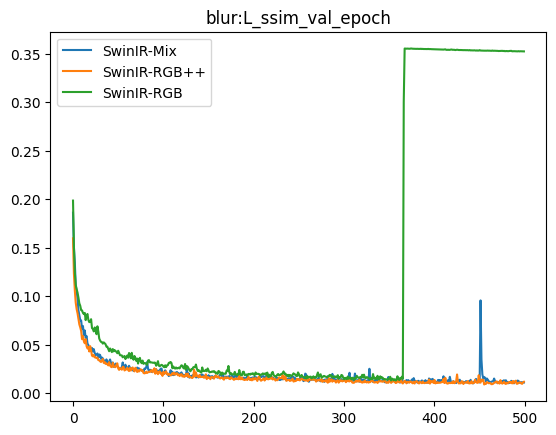

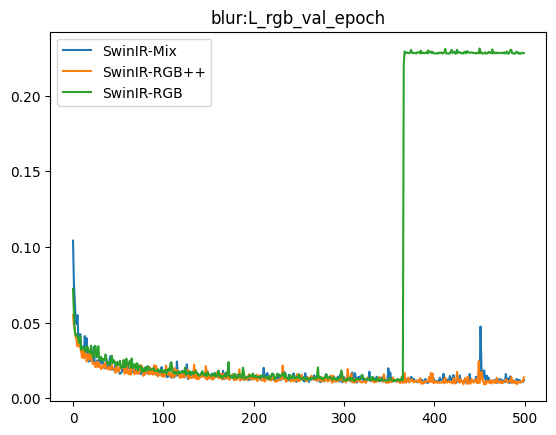

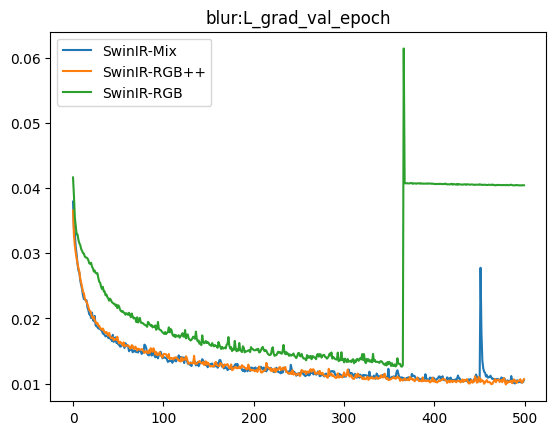

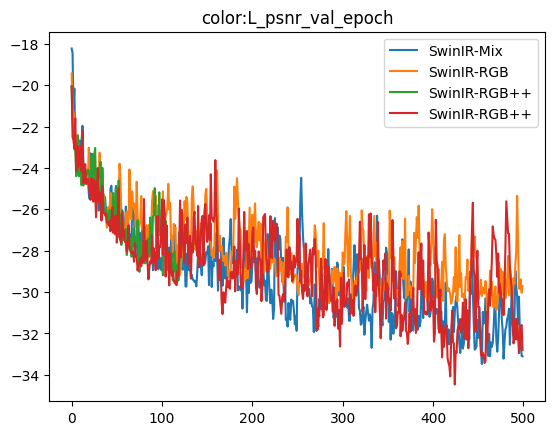

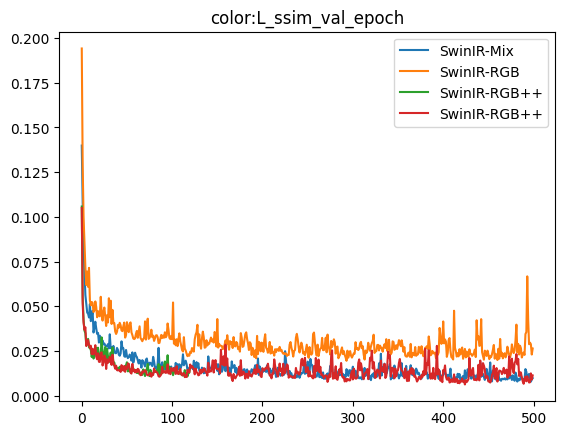

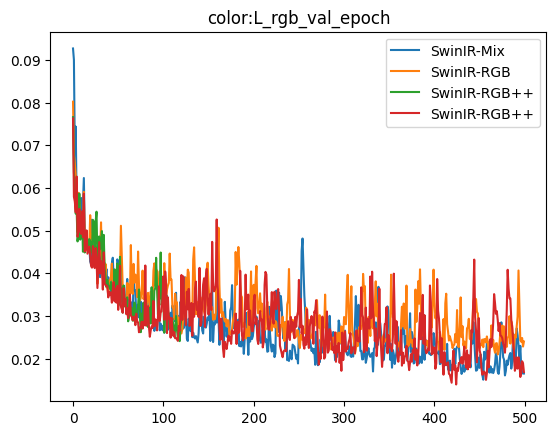

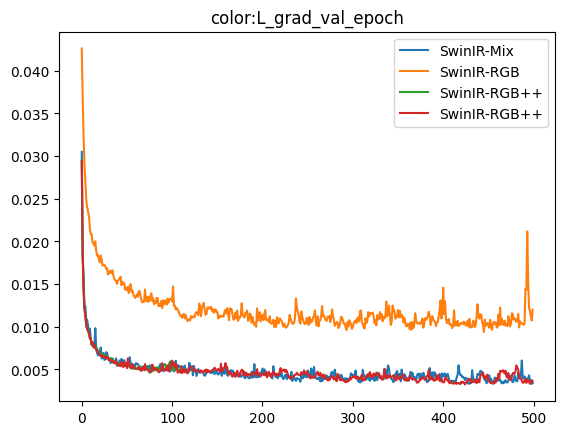

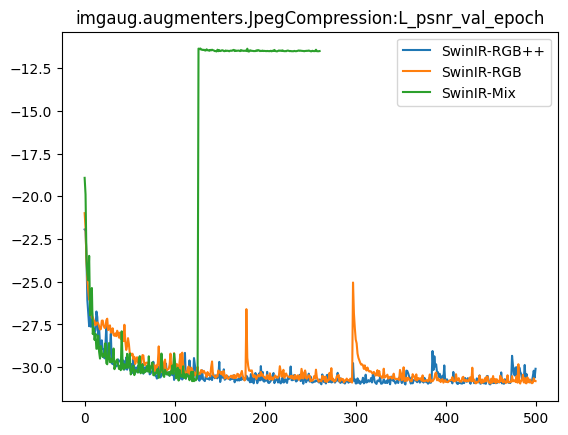

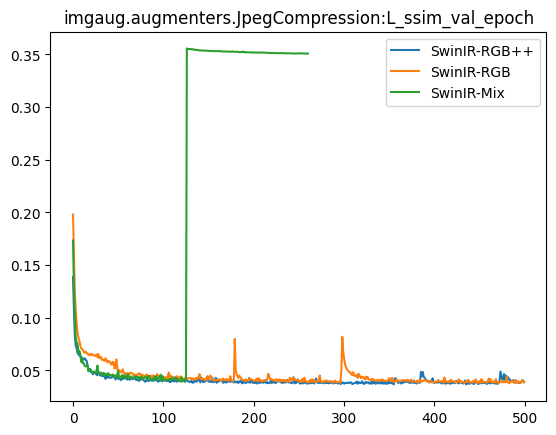

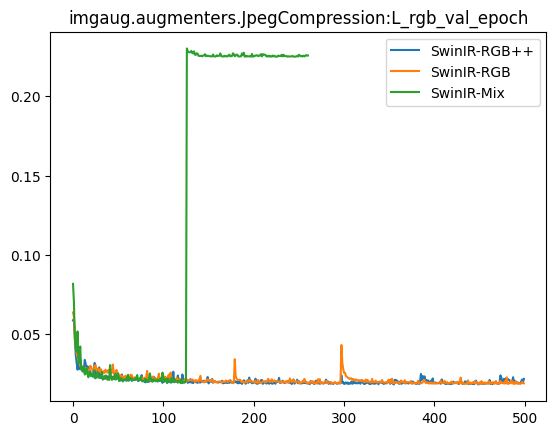

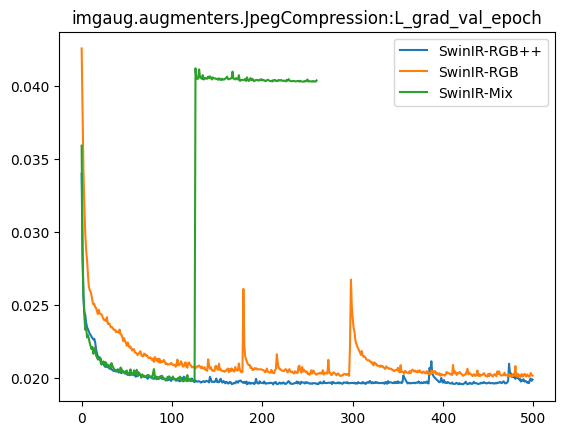

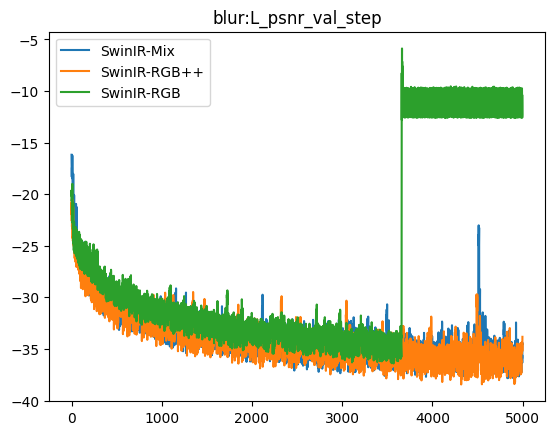

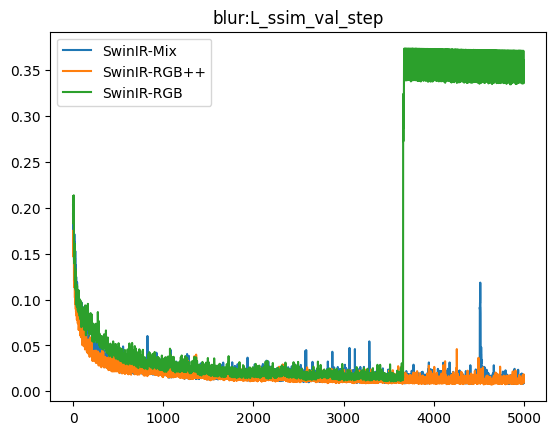

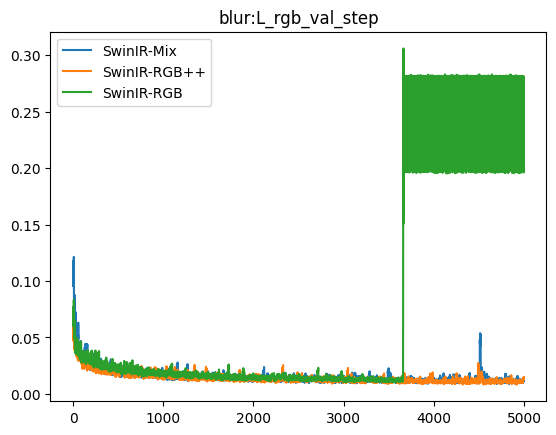

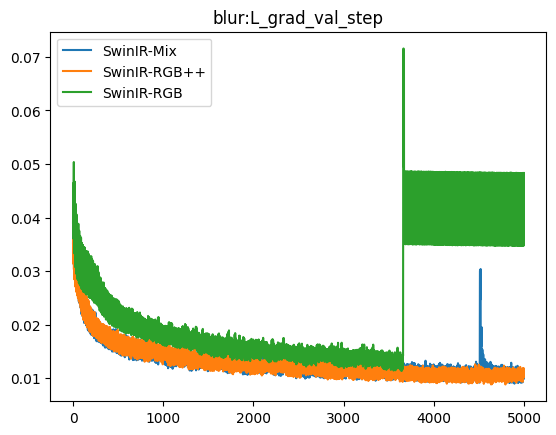

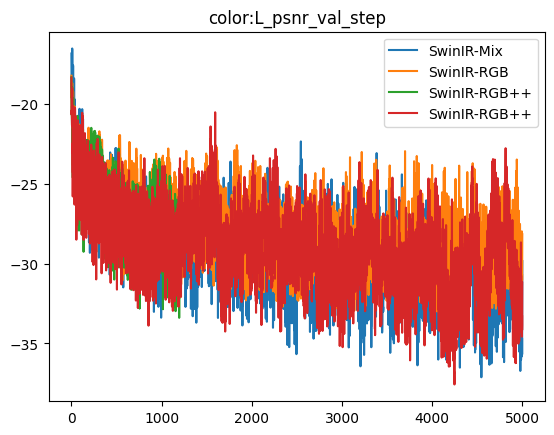

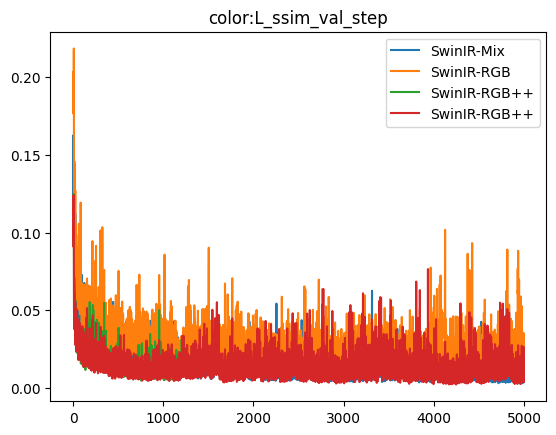

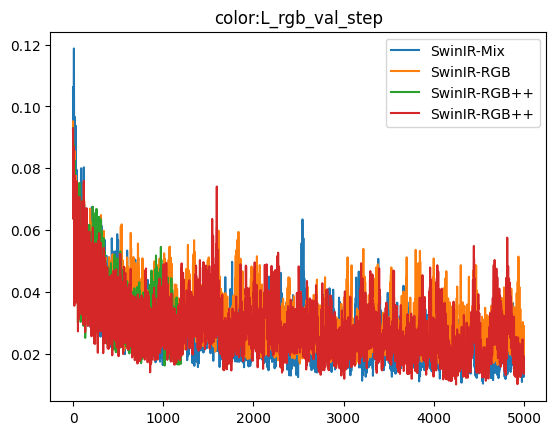

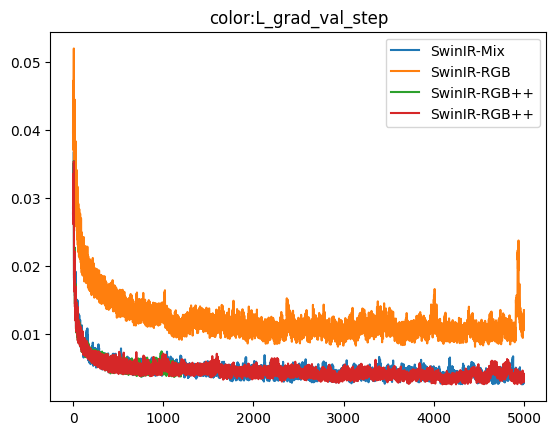

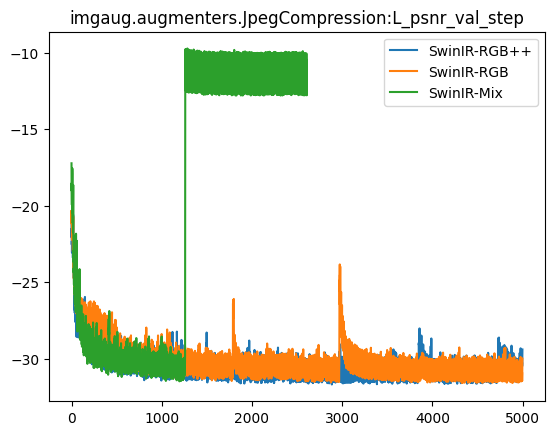

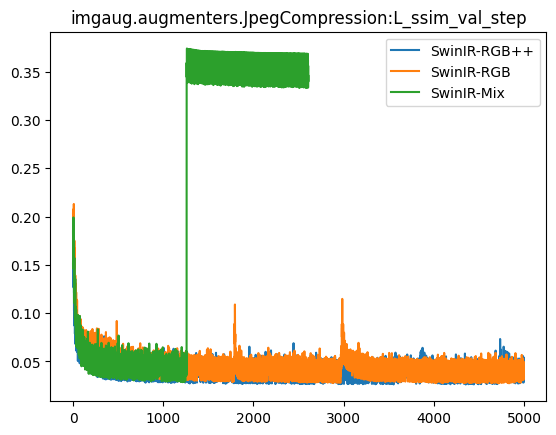

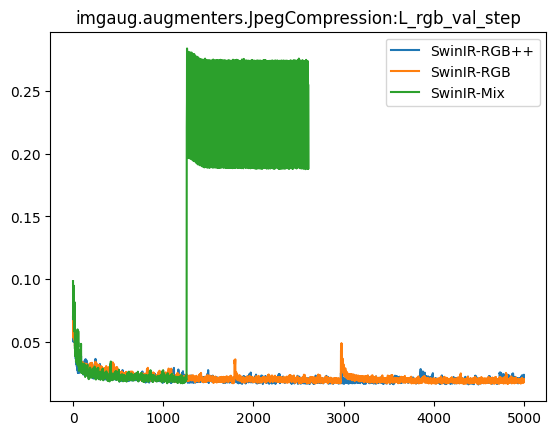

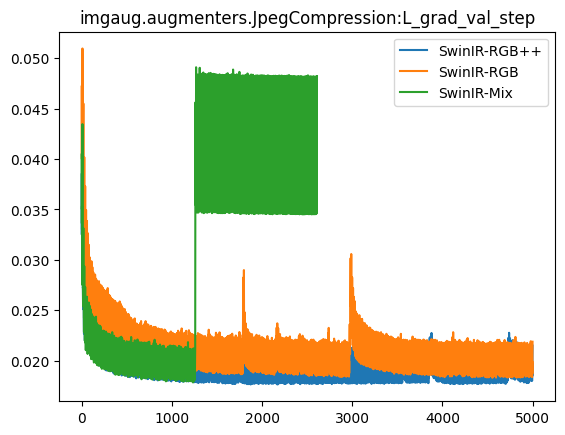

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import glob 
from pathlib import Path
versions = glob.glob("lightning_logs/*/metrics.csv")
versions = [version[:-11] for version in versions]

dfs = [ pd.read_csv(version +"/metrics.csv") for version in versions]
configs = [yaml.safe_load(Path(version +"/config.yaml").read_text()) for version in versions]

experiments = {}
for df, conf in zip(dfs,configs):
    augm = conf["data"]["augm"]
    if isinstance(augm, dict):
        augm = augm["class_path"]
    experiments.setdefault(augm, []).append((df,conf))


metrics = ["L_psnr_val_epoch","L_ssim_val_epoch","L_rgb_val_epoch","L_grad_val_epoch"]
for aug in experiments:
    for metric in metrics:
        for df, config in experiments[aug]:
            val = df[["epoch",metric]].dropna()
            plt.plot(val["epoch"],val[metric],label = config["trainer"]["name"])
        #plt.ylim(-30,-24)
        plt.title(aug+":"+metric)
        plt.legend()
        plt.show()


dfs = [ pd.read_csv(version +"/metrics.csv") for version in versions]
configs = [yaml.safe_load(Path(version +"/config.yaml").read_text()) for version in versions]
metrics = ["L_psnr_val_step","L_ssim_val_step","L_rgb_val_step","L_grad_val_step"]
for aug in experiments:
    for metric in metrics:
        for df, config in experiments[aug]:
            val = df[["step",metric]].dropna()
            plt.plot(val["step"],val[metric],label = config["trainer"]["name"])
        #plt.ylim(-30,-24)
        plt.title(aug+":"+metric)
        plt.legend()
        plt.show()

torch.Size([8, 3, 256, 256])


/tmp/ipykernel_2392/3369157148.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).permute(0, 2, 3, 1).numpy()
/tmp/ipykernel_2392/3369157148.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).permute(1, 2, 0).numpy()


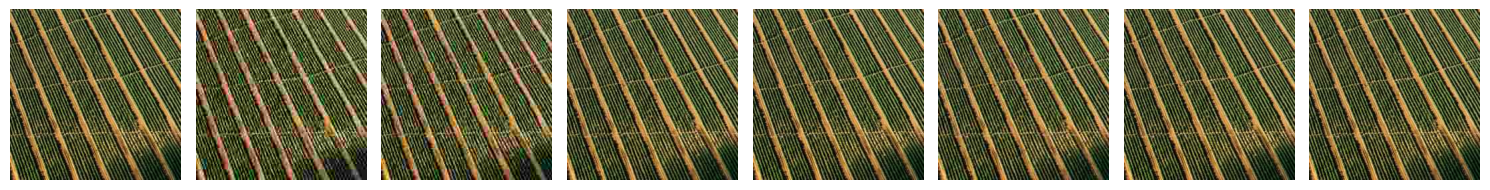

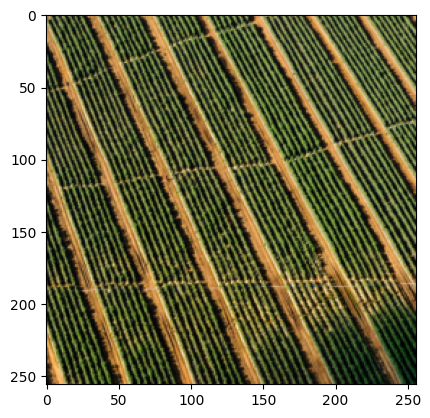

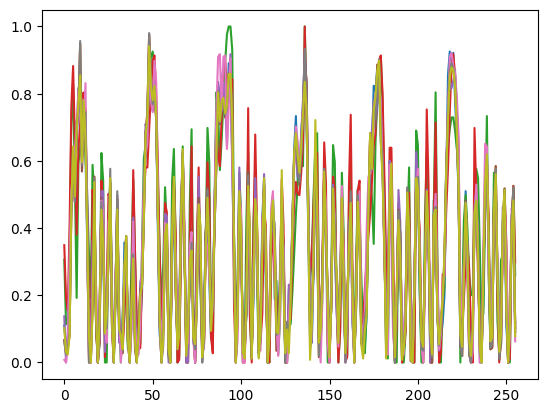

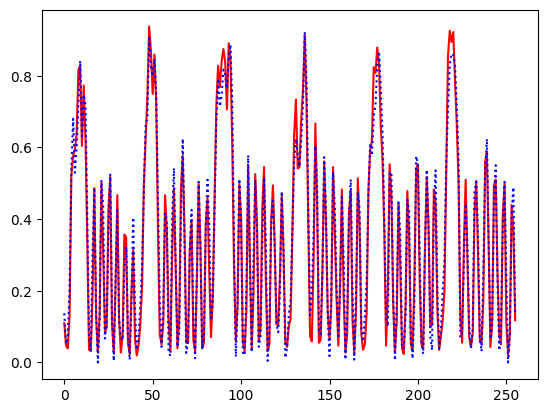

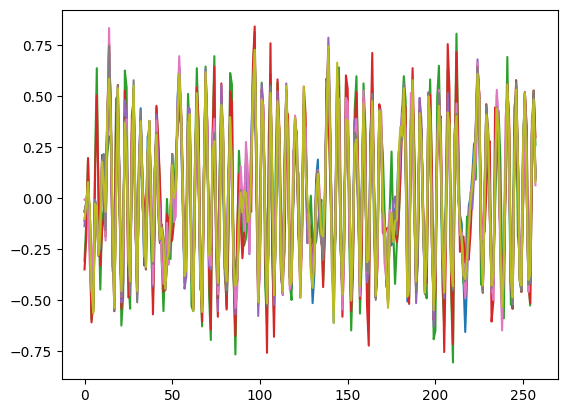

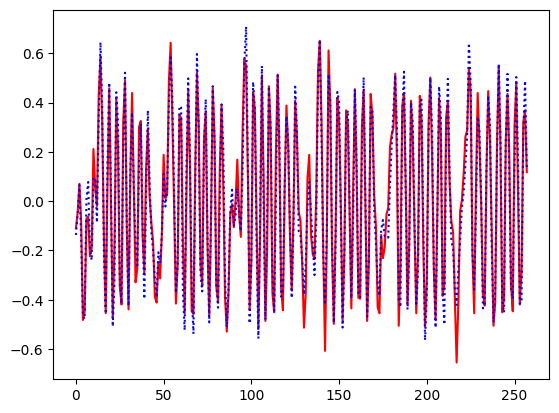

In [7]:
from models.network_swinir import SwinIR
import torch 
from torchvision.io import read_image
from torchvision.transforms import Resize
import glob
from train import DIV2K
from gradients import Mixed2RGB, RGB2Mixed
import imgaug.augmenters as iaa
from imgaug import parameters as iap
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import numpy as np


#x = x.permute(1, 2, 0).numpy()
aug = iaa.AdditiveGaussianNoise(scale=(0.1*255))
#aug = iaa.SaltAndPepper(0.1)
#aug = iaa.Grayscale(alpha=(1, 1))

aug = iaa.WithBrightnessChannels(iaa.Add((-100, 100)))
aug = iaa.MultiplyBrightness((0.5, 1.5))
aug = iaa.BlendAlphaSimplexNoise(
    foreground=iaa.Multiply(iap.Choice([0.5, 1.5]), per_channel=True),
)

augs =[
    iaa.MultiplyBrightness((0.5, 1.5)),
    iaa.WithBrightnessChannels(iaa.Add((-100, 100))),
    iaa.BlendAlphaSimplexNoise(
    foreground=iaa.Multiply(iap.Choice([0.5, 1.5]), per_channel=True),
    )]

augs_blur =[
                iaa.imgcorruptlike.GaussianBlur(severity=(1,5)),
                iaa.imgcorruptlike.DefocusBlur(severity=(1,5))
]
def augment(images,):
    aug = lambda x: np.random.choice(augs_blur)(images=[x])[0]
    res = [aug(img) for img in images]
    return res

aug = iaa.imgcorruptlike.GaussianBlur(severity=2)

aug = iaa.JpegCompression((50,99))


data = DIV2K("/shared/DIV2K/DIV2K_valid_HR/", augm=aug, len=8)

x,y = data[np.random.randint(len(data))]

print(x.size())

x = torch.tensor(x).permute(0, 2, 3, 1).numpy()
y = torch.tensor(y).permute(1, 2, 0).numpy()


fig, axes = plt.subplots(1, len(x), figsize=(15, 5))
# Plot each image
for i, img in enumerate(x):
    # If only one image, axes is not a list, so we handle that case
    if len(x) == 1:
        axes.imshow(np.asarray(img))
        axes.axis('off')
    else:
        axes[i].imshow(img)
        axes[i].axis('off')

# Display the images
plt.tight_layout()
plt.show()
plt.imshow(y, vmin=0, vmax=1)
plt.show()


line_xs= [img[128,:,0] for img in x]
line_y= y[128,:,0]

y_grad = np.convolve(line_y, [-1, 0, 1])
x_grad = [np.convolve(line_x, [-1, 0, 1]) for line_x in line_xs]

mean = np.zeros_like(line_y)
plt.plot(line_y)
for line_x in line_xs:
    mean = mean + line_x
    plt.plot(line_x)
plt.show()

plt.plot(line_y, "red")
plt.plot(mean/len(x), "b:")
plt.show()


plt.plot(y_grad)
mean = np.zeros_like(y_grad)
for line_x in line_xs:
    x_grad = np.convolve(line_x, [-1, 0, 1])
    mean = mean + x_grad
    plt.plot(x_grad)
plt.show()


plt.plot(y_grad, "r")
plt.plot(mean/len(x), "b:")
plt.show()


In [1]:
from models.model import DeepAggNet
from models.network_swinir import SwinIR3D
from einops import rearrange
import torch 
x = torch.rand(8,8,3,256,256).cuda()
print(x.size())
net = SwinIR3D(embed_dim=32).cuda()
net(x).size()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


torch.Size([8, 8, 3, 256, 256])


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.39 GiB. GPU 0 has a total capacity of 47.54 GiB of which 1.14 GiB is free. Process 2833025 has 46.40 GiB memory in use. Of the allocated memory 42.22 GiB is allocated by PyTorch, and 3.87 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)